In [1]:
import gc
import sys
import anndata
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
ABD_FIELD = "means_cell_abundance_w_sf"
ENV_LST = ["Healthy_Liver", "DownSyndrome_Liver"]
GENE_COUNT_THRESH = 800
METHOD, METRIC = "ward", "correlation"

WKDIR = "/lustre/scratch126/casm/team-cvejic/haoliang/pj_DownSyndrome/results/STx_compare_combinedVSseparate_newPip/"

In [3]:
T21_SECTIONS = ["spaceranger122_count_36337_OT_F_Visium9720395_GRCh38-3_0_0", "spaceranger122_count_36961_OT_F_Visium9998361_GRCh38-3_0_0",
                "spaceranger122_count_38823_OT_F_Visium9880863_GRCh38-3_0_0", "spaceranger122_count_38825_OT_F_Visium9880673_GRCh38-3_0_0", 
                "spaceranger122_count_36337_OT_F_Visium9720396_GRCh38-3_0_0", "spaceranger122_count_38822_OT_F_Visium9880766_GRCh38-3_0_0",
                "spaceranger122_count_38824_OT_F_Visium9880576_GRCh38-3_0_0", "spaceranger122_count_39397_OT_F_Visium10405238_GRCh38-3_0_0", 
                "spaceranger122_count_36338_OT_F_Visium9720491_GRCh38-3_0_0", "spaceranger122_count_38822_OT_F_Visium9880767_GRCh38-3_0_0", 
                "spaceranger122_count_38824_OT_F_Visium9880577_GRCh38-3_0_0", "spaceranger122_count_39397_OT_F_Visium10405239_GRCh39-3_0_0",
                "spaceranger122_count_36338_OT_F_Visium9720492_GRCh38-3_0_0", "spaceranger122_count_38822_OT_F_Visium9880768_GRCh38-3_0_0", 
                "spaceranger122_count_38825_OT_F_Visium9880670_GRCh38-3_0_0", "spaceranger122_count_39397_OT_F_Visium10405240_GRCh38-3_0_0",
                "spaceranger122_count_36644_OT_F_Visium9879893_GRCh38-3_0_0", "spaceranger122_count_38822_OT_F_Visium9880769_GRCh38-3_0_0",
                "spaceranger122_count_38825_OT_F_Visium9880671_GRCh38-3_0_0", "spaceranger122_count_39397_OT_F_Visium10405241_GRCh38-3_0_0", 
                "spaceranger122_count_36644_OT_F_Visium9879894_GRCh38-3_0_0", "spaceranger122_count_38823_OT_F_Visium9880862_GRCh38-3_0_0",
                "spaceranger122_count_38825_OT_F_Visium9880672_GRCh38-3_0_0"]
CTRL_SECTIONS = ["spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0", "spaceranger122_count_36338_OT_F_Visium9720490_GRCh38-3_0_0",
                 "spaceranger122_count_36961_OT_F_Visium9998362_GRCh38-3_0_0", "spaceranger122_count_38823_OT_F_Visium9880865_GRCh38-3_0_0",
                 "spaceranger122_count_36337_OT_F_Visium9720394_GRCh38-3_0_0", "spaceranger122_count_36644_OT_F_Visium9879895_GRCh38-3_0_0",
                 "spaceranger122_count_36961_OT_F_Visium9998363_GRCh38-3_0_0", "spaceranger122_count_36338_OT_F_Visium9720489_GRCh38-3_0_0",
                 "spaceranger122_count_36644_OT_F_Visium9879896_GRCh38-3_0_0", "spaceranger122_count_38823_OT_F_Visium9880864_GRCh38-3_0_0"]

In [4]:
WKDIR = "/lustre/scratch126/casm/team-cvejic/nelson/outputs/downsyndrome/cell2location/spatial_model/"

In [5]:
case_lst = ["Healthy_Liver/sp.h5ad", "DownSyndrome_Liver/sp.h5ad"]

In [6]:
def clean_adata(adata2clean, var_qc="total_gene_counts"):
    spot_num = {}
    spot_num["before"] = {sec: adata2clean[adata2clean.obs["sample"].isin([sec]), :].n_obs
                          for sec in adata2clean.obs["sample"].unique()}
    adata2clean = adata2clean[adata2clean.obs[var_qc] >= GENE_COUNT_THRESH, :].copy()
    spot_num["after"] = {sec: adata2clean[adata2clean.obs["sample"].isin([sec]), :].n_obs
                         for sec in adata2clean.obs["sample"].unique()}
    qc_summary = pd.DataFrame.from_dict(spot_num, orient="columns")
    qc_summary["kept percent"] = qc_summary["after"] / qc_summary["before"] * 100
    return adata2clean, qc_summary

In [7]:
def preprocess(file):
    adata = sc.read_h5ad(f"{WKDIR}{file}")
    print("* Loaded anndata:", adata, file=sys.stderr)

    # Estimated cell type abundance by cell2location
    abd_mat = adata.obsm[ABD_FIELD][[f"{ABD_FIELD.replace('_cell', 'cell')}_{ct}" for ct in adata.uns["mod"]["factor_names"]]].T
    abd_mat["cell type"] = [x.replace(f"{ABD_FIELD.replace('_cell', 'cell')}_", "").replace("-disomy", "").replace("-t21", "")
                            for x in abd_mat.index]
    abd_mat = abd_mat.groupby("cell type").sum().T
    abd_mat.rename(columns={col: f"{col} abd" for col in abd_mat.columns}, inplace=True)
    idx_ori = adata.obs_names.copy()
    adata.obs = pd.concat([adata.obs, abd_mat], axis=1, verify_integrity=True)
    assert (adata.obs_names == idx_ori).all()

    # Expression matrix and QC metrics
    exp_mat = pd.DataFrame.sparse.from_spmatrix(adata.X, columns=adata.var.index, index=adata.obs.index)
    adata.obs["total_gene_counts"] = exp_mat.sum(axis=1)
    adata.obs["total_cell_counts"] = adata.obsm[ABD_FIELD].sum(axis=1)

    # Clean data
    adata, qc_summary = clean_adata(adata)
    print("shape of adata:", adata.shape, file=sys.stderr)
    print("shape of adata.obs:", adata.obs.shape, file=sys.stderr)
    print("shape of adata.obsm:", adata.obsm[ABD_FIELD].shape, file=sys.stderr)
    return adata.copy()

In [8]:
def plot_dendro(df, metric, method, ax, title):
    dist = pdist(df.T, metric=metric)
    dendrogram(linkage(dist, method=method, metric=metric),
               labels=df.columns, orientation="left",
               leaf_font_size=12, ax=ax)
    xlbls = ax.get_ymajorticklabels()
    for lbl in xlbls:
        if lbl.get_text() in ["HSCs/MPPs", "Cycling HSCs/MPPs"]:
            lbl.set_color("red")
        elif lbl.get_text() in ["Hepatocytes", "Hepatic stellate cells", "Activated stellate cells", "LSECs", "Vascular endothelial cells"]:
            lbl.set_color("blue")
        else:
            lbl.set_color("black")
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(True)
    ax.tick_params(left=False, right=False, labelleft=False,
                   labelbottom=True, bottom=True)
    ax.set_title(title, horizontalalignment="left")

* Loaded anndata: AnnData object with n_obs × n_vars = 22530 × 24565
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', '_scvi_batch', '_scvi_labels', '_indices'
    var: 'feature_types', 'genome', 'mt', 'n_cells_by_counts-spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0', 'mean_counts-spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0', 'log1p_mean_counts-spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0', 'pct_dropout_by_counts-spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0', 'total_counts-spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0', 'log1p_total_counts-spaceranger122_count_36337_OT_F_Visium9720393_GRCh38-3_0_0', 'n_cells_by_counts-spaceranger122_count_36337_OT_F_Visium9720394_GRCh38-3_0_0', 'mean_counts-sp

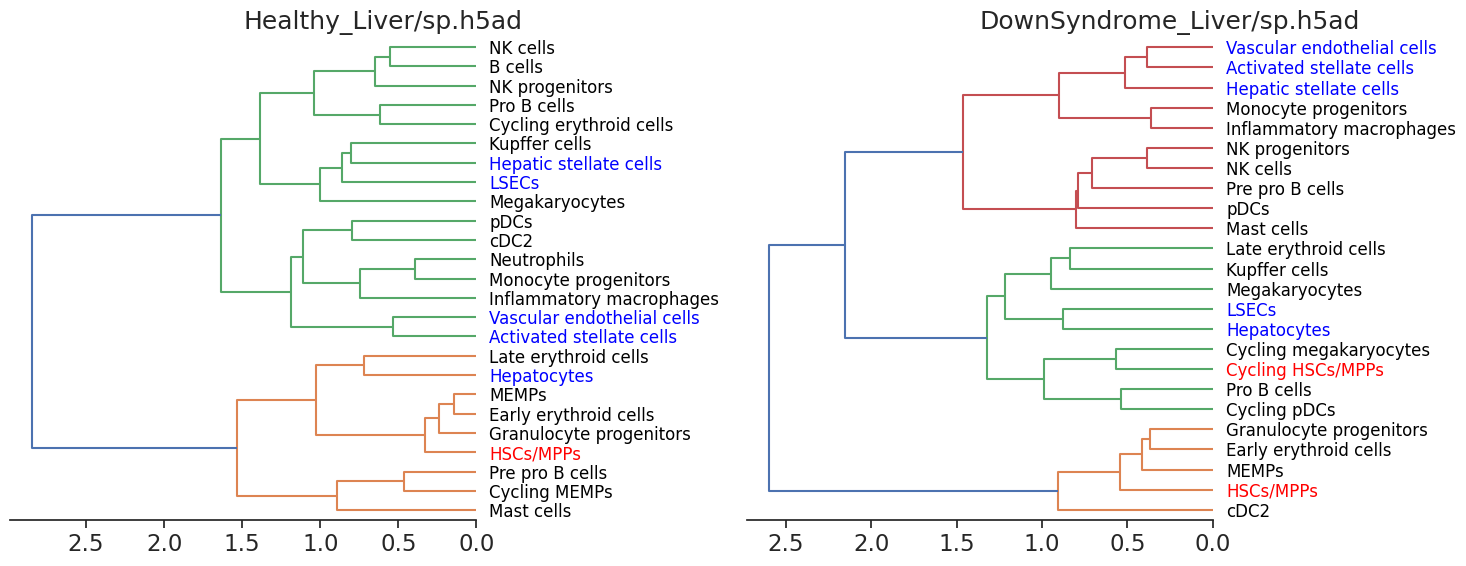

In [9]:
adata_lst = [preprocess(case) for case in case_lst]
print(adata_lst[0], file=sys.stderr)
print(adata_lst[1], file=sys.stderr)

# Plot dendrograms
sns.set_theme(font_scale=1.5, style="white")
_, axes = plt.subplots(1, 2, figsize=(15, 6))
# Load cleaned data, transform counts, and harmonisation
for i, adata in enumerate(adata_lst):
    all_ctypes = [col.replace(" abd", "") for col in adata.obs.columns if " abd" in col]
    ctype_pct_spot = adata.obs[[f"{x} abd" for x in all_ctypes]].copy()
    ctype_pct_spot.rename(columns={x: x.replace(" abd", "") for x in ctype_pct_spot.columns}, inplace=True)
    perspot_sum = ctype_pct_spot.sum(axis=1)
    for col in ctype_pct_spot.columns:
        ctype_pct_spot[col] *= (100 / perspot_sum)
    # Plot dendrogram for cell type colocalisation
    plot_dendro(ctype_pct_spot, METRIC, METHOD, axes[i], case_lst[i])
    del ctype_pct_spot
plt.tight_layout()